In [1]:
import sys, torch, torchvision, torch.nn as nn, torch.optim as optim, numpy as np

from navigation_mdp.state import State, DiscreteStateSpace
from navigation_mdp.class_ import XYClassDistribution
from navigation_mdp.dynamics import XYDynamics
from navigation_mdp.features import FeatureStateIndicator, FeatureStateIndicatorOneHot, \
                                        FeatureClassIndicator, FeatureClassIndicatorOneHot, \
                                        FeatureClassImage, FeatureClassImageSampler
from navigation_mdp.reward import RewardStateScalar
import rl.planning as Plan
import rl.policy as Policy
import rl.reward as Reward

sys.path.append("./NavigationGridViews/")
from NavigationGridViews.navgridviews.Raster import Raster as NavGridView

from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

In [2]:
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

def sample_image(X, y, y_q):
    x_q = X[y == y_q]
    return x_q[np.random.randint(0, len(x_q))]

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


In [3]:
np.random.seed(5)
# Specify state space
S = DiscreteStateSpace(5,5)
goal = (4,4)

# Attach classes
class_ids = XYClassDistribution([
        
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]],
        marker_to_class_id = {
            1: 76,
            0: 68
        },
    )().flatten()

S.attach_classes(class_ids)
S.override_classes_by_loc([goal], [68])
# Attach features
S.attach_features(FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))
PHI_gridded = S.features(gridded=True)
PHI_gridded_vis = np.flip(PHI_gridded, 2)
# Attach rewards
S.attach_rewards(RewardStateScalar(S, loc_to_reward_dict={goal: 1}, class_id_to_reward_dict={
    37: 0, 76: 0, 68: 0}, default=0))
R = S.rewards()
# Specify dynamics
T = XYDynamics(S, slip_prob=0.)
# Set goal
S.set_terminal_status_by_loc([goal])
# Value Iteration
# VI = Plan.ValueIteration(S, R, T, verbose=True)
# VI.q_value_list(S[23], False)

PHI = torch.FloatTensor(S.features()).permute(0,3,1,2) / 255.
R_model = Reward.ConvAE((3, 32, 32))

In [4]:
optimizer_fn = lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
lr = 0.01
weight_decay=0
optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

In [5]:
optimizer.zero_grad()
R_nonlin = R_model.reward(PHI)
VI = Plan.ValueIteration(S, R_nonlin, T, verbose=True, log_pi=False)
log_Pi, V, Q, iterno = VI.run(100, lambda q: Policy.Boltzmann(q, boltzmann_temp=1.), 
                              verbose=True, debug=False, eps=1e-6)

Running VI [  ] VI converged @ 28.


In [6]:
# loss = -VI.V[0]
# loss.backward()
# torch.sum(R_model.fc1.weight.grad)

# T.ACTIONS: ['U', 'D', 'L', 'R']
loss = -log_Pi[24,0]
loss += -log_Pi[1,2]
loss.backward()
optimizer.step()
print(torch.sum(R_model.fc1.weight.grad))

tensor(12.0711)


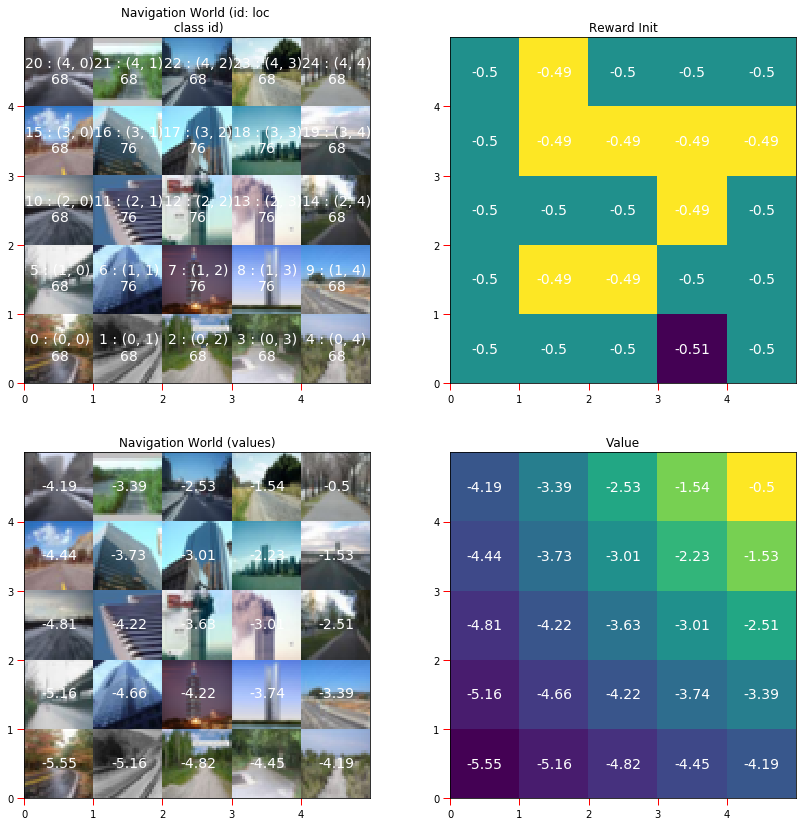

In [7]:
fig = plt.figure(figsize=(14,14))
state_ann_sz = 14
state_ann_color = "white"
plt.subplot(2,2,1)
state_cls_ids_lst = [str(idx) + " : " + str(s.location) + "\n" + str(s.class_id) for idx, s in enumerate(S.state_lst)]
p = NavGridView(PHI_gridded_vis, ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    state_cls_ids_lst, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Navigation World (id: loc \n class id)")
# plt.colorbar(p.im)
p.ax.invert_yaxis()

plt.subplot(2,2,2)
R_disp = R_nonlin.detach().numpy().round(2)
p = NavGridView(R_disp[..., np.newaxis, np.newaxis], ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    R_disp.squeeze(), fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Reward Init")
# plt.colorbar(p.im)
p.ax.invert_yaxis()

plt.subplot(2,2,3)
p = NavGridView(PHI_gridded_vis, ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    V.detach().numpy().round(2), fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Navigation World (values)")
p.ax.invert_yaxis()

plt.subplot(2,2,4)
p = NavGridView(S._organize_to_grid(V.detach().numpy())[..., np.newaxis, np.newaxis, np.newaxis], 
                ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    V.detach().numpy().round(2), fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Value")
p.ax.invert_yaxis()

In [8]:
R_nonlin

tensor([[-0.4974],
        [-0.4966],
        [-0.5028],
        [-0.5053],
        [-0.4997],
        [-0.4993],
        [-0.4878],
        [-0.4949],
        [-0.4962],
        [-0.5007],
        [-0.4978],
        [-0.4979],
        [-0.4962],
        [-0.4936],
        [-0.5007],
        [-0.5016],
        [-0.4895],
        [-0.4946],
        [-0.4908],
        [-0.4926],
        [-0.5014],
        [-0.4932],
        [-0.5010],
        [-0.5029],
        [-0.4984]], grad_fn=<NegBackward>)